<a href="https://colab.research.google.com/github/Madhuri-nallamothu/AutoGAN/blob/main/braintumor_using_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121, ResNet50, MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt

In [6]:
 pip install tensorflow

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
extract_path = '/content/drive/MyDrive/Brain/Training'

In [9]:
!ls "/content/drive/MyDrive/Brain/Testing/"

glioma	meningioma  notumor  pituitary


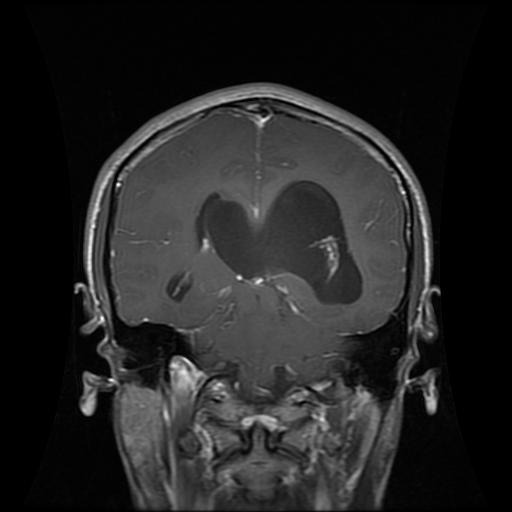

In [10]:
from PIL import Image

sample_image = Image.open('/content/drive/MyDrive/Brain/Training/glioma/Tr-glTr_0002.jpg')
sample_image

In [11]:
width, height = sample_image.size
print(f"Width: {width} pixels")
print(f"Height: {height} pixels")


Width: 512 pixels
Height: 512 pixels


In [12]:
import os

class_directory = '/content/drive/MyDrive/Brain/Training/pituitary'
image_files = [f for f in os.listdir(class_directory) if f.endswith('.jpg')]
print(image_files)  # List the images in the glioma folder


['Tr-pi_0263.jpg', 'Tr-pi_0277.jpg', 'Tr-pi_0505.jpg', 'Tr-pi_0288.jpg', 'Tr-pi_0075.jpg', 'Tr-pi_0115.jpg', 'Tr-pi_0101.jpg', 'Tr-pi_0061.jpg', 'Tr-pi_0129.jpg', 'Tr-pi_0049.jpg', 'Tr-pi_0471.jpg', 'Tr-pi_0464.jpg', 'Tr-pi_0303.jpg', 'Tr-pi_0458.jpg', 'Tr-pi_0465.jpg', 'Tr-pi_0317.jpg', 'Tr-pi_0470.jpg', 'Tr-pi_0316.jpg', 'Tr-pi_0459.jpg', 'Tr-pi_0302.jpg', 'Tr-pi_0048.jpg', 'Tr-pi_0060.jpg', 'Tr-pi_0128.jpg', 'Tr-pi_0114.jpg', 'Tr-pi_0289.jpg', 'Tr-pi_0074.jpg', 'Tr-pi_0100.jpg', 'Tr-pi_0089.jpg', 'Tr-pi_0248.jpg', 'Tr-pi_0276.jpg', 'Tr-pi_0274.jpg', 'Tr-pi_0262.jpg', 'Tr-pi_0062.jpg', 'Tr-pi_0506.jpg', 'Tr-pi_0260.jpg', 'Tr-pi_0076.jpg', 'Tr-pi_0504.jpg', 'Tr-pi_0314.jpg', 'Tr-pi_0472.jpg', 'Tr-pi_0102.jpg', 'Tr-pi_0116.jpg', 'Tr-pi_0328.jpg', 'Tr-pi_0300.jpg', 'Tr-pi_0329.jpg', 'Tr-pi_0498.jpg', 'Tr-pi_0499.jpg', 'Tr-pi_0466.jpg', 'Tr-pi_0063.jpg', 'Tr-pi_0117.jpg', 'Tr-pi_0088.jpg', 'Tr-pi_0103.jpg', 'Tr-pi_0473.jpg', 'Tr-pi_0315.jpg', 'Tr-pi_0467.jpg', 'Tr-pi_0301.jpg', 'Tr-pi_02

In [13]:
print(os.listdir('/content/drive/MyDrive/Brain/Training'))


['.DS_Store', 'glioma', 'notumor', 'meningioma', 'pituitary']


Train-Test Split

In [14]:
def custom_train_test_split(dataset_directory, test_ratio=0.2, random_seed=None, min_samples_per_class=2):
    """
    Custom function to perform a stratified train-test split on an image dataset.
    This function organizes the dataset into 'train' and 'test' directories while maintaining the class-wise distribution.
    It creates the 'train' and 'test' directories within the given dataset directory and moves images accordingly.
    """
    random_seed = random_seed or 42

    class_directories = [d for d in os.listdir(dataset_directory) if os.path.isdir(os.path.join(dataset_directory, d))]

    train_directory = os.path.join(dataset_directory, 'train')
    test_directory = os.path.join(dataset_directory, 'test')
    os.makedirs(train_directory, exist_ok=True)
    os.makedirs(test_directory, exist_ok=True)

    for class_dir in class_directories:
        class_path = os.path.join(dataset_directory, class_dir)

        image_files = [f for f in os.listdir(class_path) if f.endswith('.jpg')]

        if len(image_files) < min_samples_per_class:
            continue

        train_images, test_images = train_test_split(image_files, test_size=test_ratio, random_state=random_seed)

        for train_image in train_images:
            src_image_path = os.path.join(class_path, train_image)
            src_annotation_path = os.path.join(class_path, train_image.replace('.jpg', '.txt'))

            dest_image_path = os.path.join(train_directory, class_dir, train_image)
            dest_annotation_path = os.path.join(train_directory, class_dir, train_image.replace('.jpg', '.txt'))

            os.makedirs(os.path.dirname(dest_image_path), exist_ok=True)

            if os.path.exists(src_annotation_path):
                shutil.move(src_image_path, dest_image_path)
                shutil.move(src_annotation_path, dest_annotation_path)

        for test_image in test_images:
            src_image_path = os.path.join(class_path, test_image)
            src_annotation_path = os.path.join(class_path, test_image.replace('.jpg', '.txt'))

            dest_image_path = os.path.join(test_directory, class_dir, test_image)
            dest_annotation_path = os.path.join(test_directory, class_dir, test_image.replace('.jpg', '.txt'))

            os.makedirs(os.path.dirname(dest_image_path), exist_ok=True)

            if os.path.exists(src_annotation_path):
                shutil.move(src_image_path, dest_image_path)
                shutil.move(src_annotation_path, dest_annotation_path)



In [15]:
# Define paths
train_dir = "/content/drive/MyDrive/Brain/Training"  # Replace with the path to your train folder
test_dir = "/content/drive/MyDrive/Brain/Testing"    # Replace with the path to your test folder

# Image dimensions and batch size
img_width, img_height = 512, 512  # Standard size for DenseNet, ResNet, MobileNet
batch_size = 32

# Data augmentation and preprocessing for training data
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Normalize pixel values to [0, 1]
    rotation_range=20,     # Data augmentation
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Preprocessing for test data (only rescaling)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Load training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Load test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Do not shuffle test data
)

Found 2051 images belonging to 4 classes.
Found 410 images belonging to 4 classes.


In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define parameters
test_dir = '/content/drive/MyDrive/Brain/Testing'  # Change to the actual test directory path
img_width, img_height = 224, 224  # Or the size your model expects
batch_size = 32  # Or as per your preference

# Create ImageDataGenerator for test set
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Generate batches of tensor image data from the test directory
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)


Found 410 images belonging to 4 classes.


In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up directory and parameters
train_dir = '/content/drive/MyDrive/Brain/Training'  # Change this path to your actual training data directory
img_width, img_height = 224, 224
batch_size = 32

# Create the training data generator
train_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical"
)


Found 2051 images belonging to 4 classes.


In [18]:
class_dict = train_generator.class_indices
classes = list(class_dict.keys())


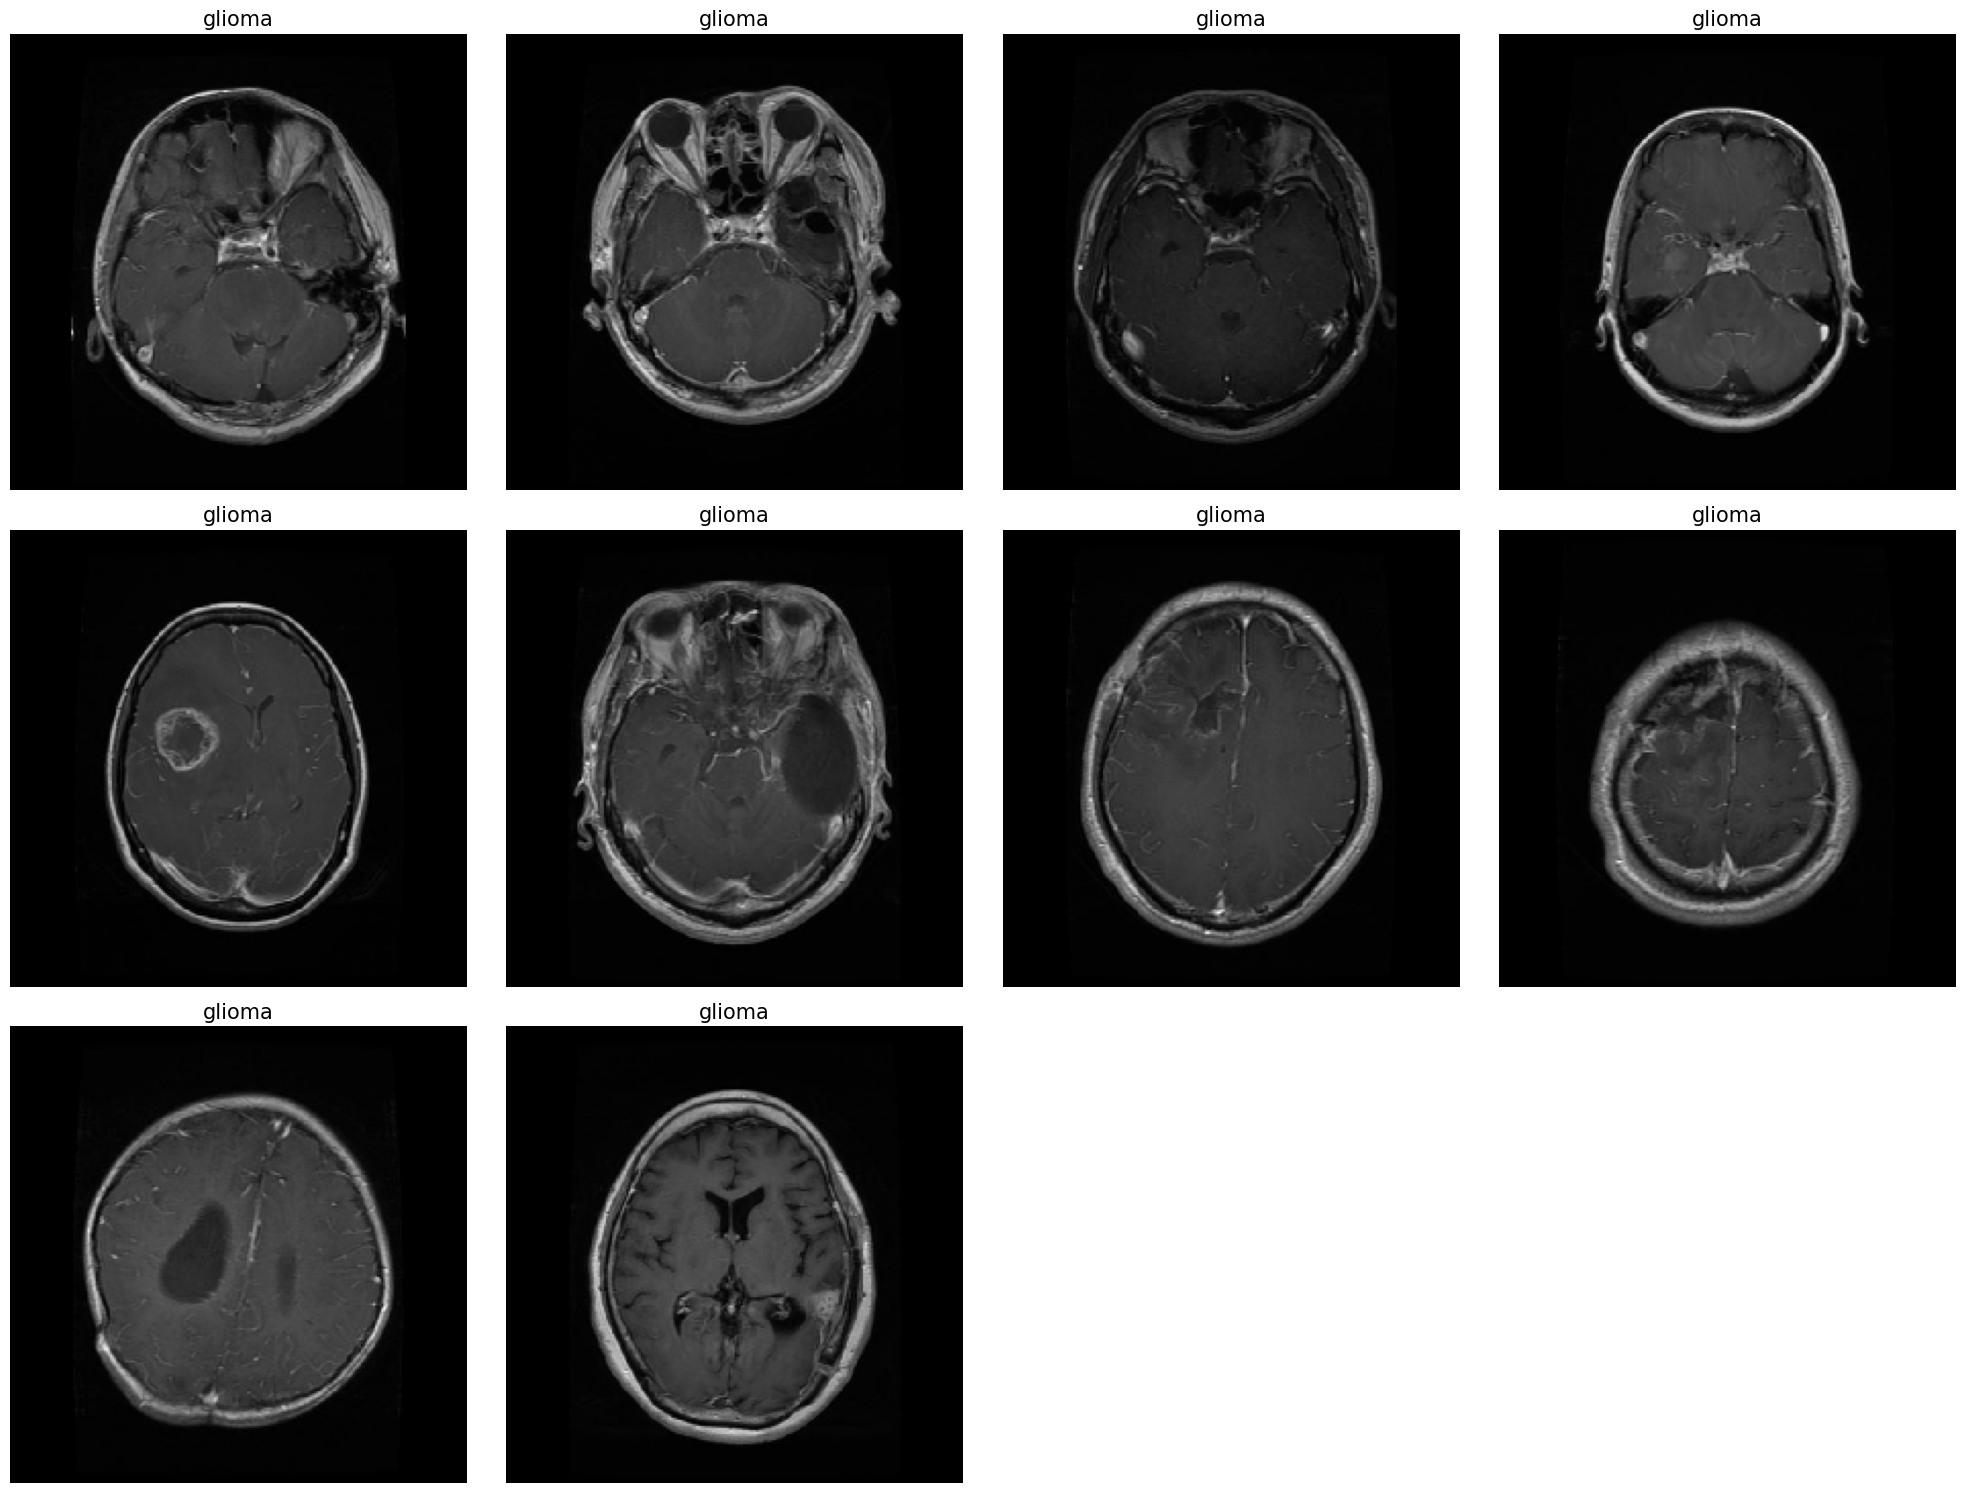

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Get class indices from training data
class_dict = train_generator.class_indices
classes = list(class_dict.keys())

# Get a batch of images and labels from the test generator
images, labels = next(test_generator)

# Plotting the images with their actual class names
plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    if i >= 10:  # display only the first 16 images
        break
    plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)
    plt.axis('off')

plt.tight_layout()
plt.show()


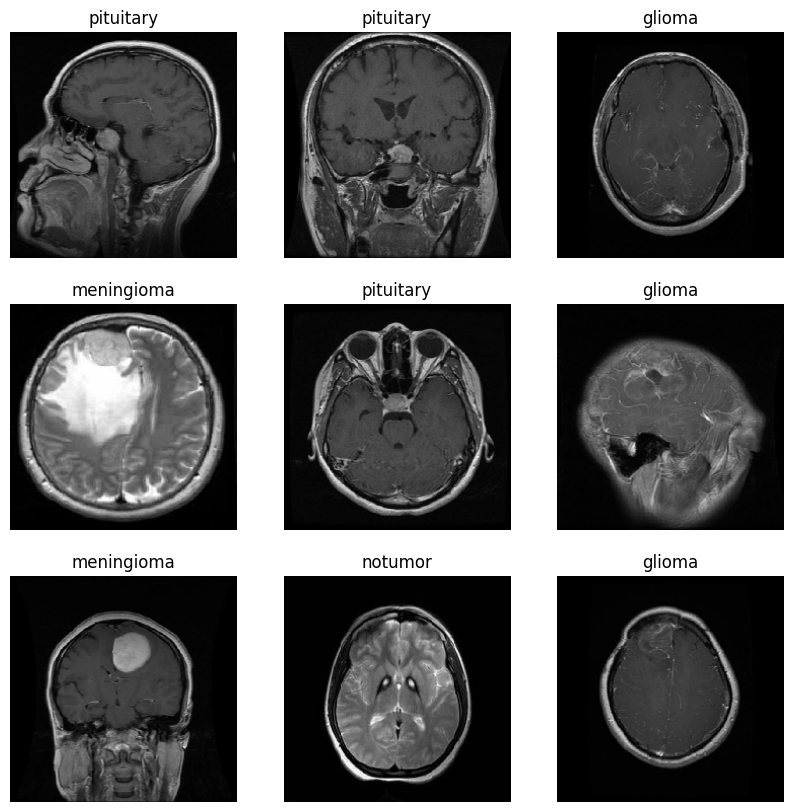

In [20]:
# Get a batch of images and labels from the train_generator
images, labels = next(train_generator)

# Class names
class_names = list(train_generator.class_indices.keys())

# Display images
plt.figure(figsize=(10, 10))
for i in range(9):  # Display 9 images
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis('off')
plt.show()

Importing DenseNet121

In [21]:
def create_densenet_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)  # Added L2 regularization
    x = Dropout(0.6)(x)  # Increased dropout rate for better generalization
    predictions = Dense(4, activation='softmax')(x)  # 4 classes
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [22]:
create_densenet_model().summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 7,564,356 (28.86 MB)

 Trainable params: 7,480,708 (28.54 MB)

 Non-trainable params: 83,648 (326.75 KB)

IMporting Resnet50

Create_resnet_model() . It builds a custom image classification model using ResNet50 as the base and adds a few custom layers on top.

In [23]:
def create_resnet_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    predictions = Dense(4, activation='softmax')(x)  # 4 classes
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [24]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam  # Or another optimizer of your choice

# Define image dimensions
img_width, img_height = 224, 224  # Make sure this matches your input image size

# Model creation function
def create_resnet_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    predictions = Dense(4, activation='softmax')(x)  # 4 classes
    model = Model(inputs=base_model.input, outputs=predictions)
    return model


In [25]:
model = create_resnet_model()
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,638,852 (93.99 MB)

 Trainable params: 24,585,732 (93.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [26]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam  # optional, for compiling later

# Ensure your image dimensions are set
img_width, img_height = 224, 224  # or whatever size MobileNet expects

# Define the MobileNet-based model
def create_mobilenet_model():
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    predictions = Dense(4, activation='softmax')(x)  # 4 output classes
    model = Model(inputs=base_model.input, outputs=predictions)
    return model


In [27]:
model = create_mobilenet_model()
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,755,716 (14.33 MB)

 Trainable params: 3,733,828 (14.24 MB)

 Non-trainable params: 21,888 (85.50 KB)

## Training Layers

training and saving the DenseNet model (It contains model compilation, callbacks, fitting, and saving )

In [28]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [29]:
def create_densenet_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    predictions = Dense(4, activation='softmax')(x)  # 4 output classes
    model = Model(inputs=base_model.input, outputs=predictions)
    return model


In [30]:
# Train DenseNet
densenet_model = create_densenet_model()
densenet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for improved training
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)

history_densenet = densenet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=5,
    callbacks=[early_stopping, reduce_lr]  # Added callbacks for improved stability
)

# Save DenseNet model
densenet_model.save("densenet_model.h5")
print("DenseNet model saved as densenet_model.h5")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 1726s 24s/step - accuracy: 0.6286 - loss: 1.5887 - val_accuracy: 0.5234 - val_loss: 2.3701 - learning_rate: 1.0000e-04
Epoch 2/5
 1/64 ━━━━━━━━━━━━━━━━━━━━ 22s 356ms/step - accuracy: 0.9062 - loss: 0.8032

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 311ms/step - accuracy: 0.9062 - loss: 0.8032 - val_accuracy: 0.5391 - val_loss: 2.3707 - learning_rate: 1.0000e-04
Epoch 3/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 43s 327ms/step - accuracy: 0.9368 - loss: 0.7634 - val_accuracy: 0.7005 - val_loss: 1.9737 - learning_rate: 1.0000e-04
Epoch 4/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9375 - loss: 0.6993 - val_accuracy: 0.7057 - val_loss: 1.9310 - learning_rate: 1.0000e-04
Epoch 5/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 38s 316ms/step - accuracy: 0.9795 - loss: 0.5982 - val_accuracy: 0.7396 - val_loss: 1.3176 - learning_rate: 1.0000e-04


DenseNet model saved as densenet_model.h5


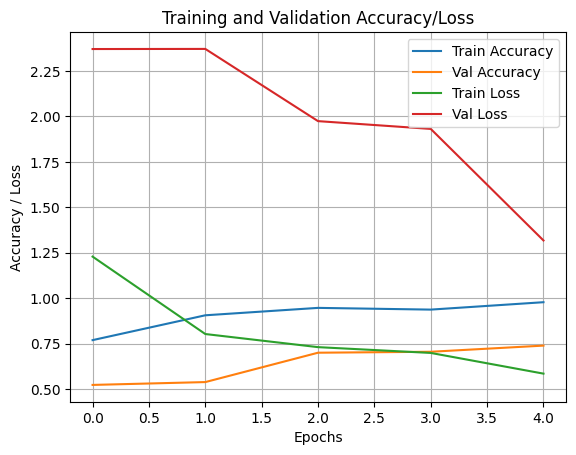

In [31]:
import matplotlib.pyplot as plt

# Plot accuracy and loss
plt.plot(history_densenet.history['accuracy'], label='Train Accuracy')
plt.plot(history_densenet.history['val_accuracy'], label='Val Accuracy')
plt.plot(history_densenet.history['loss'], label='Train Loss')
plt.plot(history_densenet.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training and Validation Accuracy/Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy / Loss")
plt.grid(True)
plt.show()


In [34]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

def create_resnet_model(input_shape=(224, 224, 3), num_classes=4):
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model


In [35]:
import os

dataset_path = "/content/drive/MyDrive/Brain/Testing"  # Adjust this!
if os.path.exists(dataset_path):
    print("✅ Dataset found!")
    print(os.listdir(dataset_path))  # List folder contents
else:
    print("❌ Dataset path is incorrect. Check and update it.")


✅ Dataset found!
['.DS_Store', 'meningioma', 'pituitary', 'glioma', 'notumor']


In [36]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
img_size = (224, 224)

# Data Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Training Generator
train_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/Brain/Training",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training"
)

# Validation Generator
test_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/Brain/Testing",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation"
)


Found 1641 images belonging to 4 classes.
Found 82 images belonging to 4 classes.


In [37]:
resnet_model = create_resnet_model()


In [38]:
resnet_model = create_resnet_model()
resnet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for improved training
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)

history_resnet = resnet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

# Save ResNet model
resnet_model.save("resnet_model.h5")
print("ResNet model saved as resnet_model.h5")

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 109s 839ms/step - accuracy: 0.6874 - loss: 0.7455 - val_accuracy: 0.1875 - val_loss: 3.0168 - learning_rate: 1.0000e-04
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9375 - loss: 0.1653 - val_accuracy: 0.2031 - val_loss: 3.0654 - learning_rate: 1.0000e-04
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 23s 304ms/step - accuracy: 0.9809 - loss: 0.0733 - val_accuracy: 0.2031 - val_loss: 3.4645 - learning_rate: 1.0000e-04
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9375 - loss: 0.1938 - val_accuracy: 0.2188 - val_loss: 3.4040 - learning_rate: 5.0000e-05
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 16s 311ms/step - accuracy: 0.9868 - loss: 0.0502 - val_accuracy: 0.2656 - val_loss: 5.2385 - learning_rate: 5.0000e-05


ResNet model saved as resnet_model.h5


In [39]:
from tensorflow.keras.models import load_model

# Load the saved model
resnet_model = load_model("resnet_model.h5")  # or "densenet_model.keras"
print("ResNet model reloaded successfully!")


ResNet model reloaded successfully!


In [40]:
resnet_model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,638,854 (93.99 MB)

 Trainable params: 24,585,732 (93.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 2 (12.00 B)

In [41]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


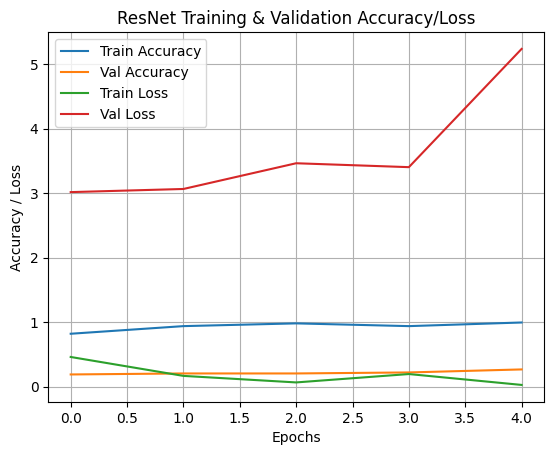

In [42]:
import matplotlib.pyplot as plt

# Accuracy & Loss plots
plt.plot(history_resnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Val Accuracy')
plt.plot(history_resnet.history['loss'], label='Train Loss')
plt.plot(history_resnet.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("ResNet Training & Validation Accuracy/Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy / Loss")
plt.grid(True)
plt.show()


In [43]:
from tensorflow.keras.models import load_model
resnet_loaded = load_model("resnet_model.h5")


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


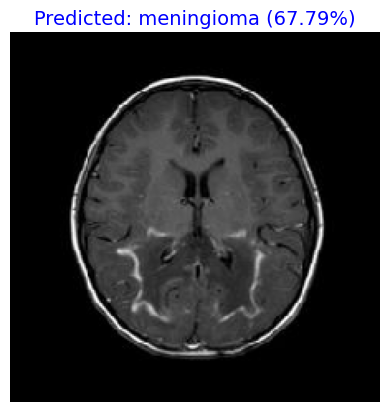

Actual class: notumor


In [48]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('resnet_model.h5')

# Test data directory
test_dir = '/content/drive/MyDrive/Brain/Testing'  # adjust as needed
class_names = sorted(os.listdir(test_dir))  # folder names as class labels

# Randomly select class and image
random_class = random.choice(class_names)
class_path = os.path.join(test_dir, random_class)
random_image = random.choice(os.listdir(class_path))
img_path = os.path.join(class_path, random_image)

# Image preprocessing
img = image.load_img(img_path, target_size=(img_width, img_height))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Predict
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions)
confidence = np.max(predictions)

# Display
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {class_names[predicted_class]} ({confidence*100:.2f}%)", fontsize=14, color='blue')
plt.show()

print(f"Actual class: {random_class}")


In [49]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)


In [50]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

def create_mobilenet_model(num_classes=5):  # Adjust num_classes for your problem
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model


In [51]:
num_classes = train_generator.num_classes
print("Number of classes:", num_classes)



Number of classes: 4


In [52]:
def create_mobilenet_model(num_classes=4):  # Set to the actual number
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model


In [53]:
mobilenet_model = create_mobilenet_model(num_classes=train_generator.num_classes)


In [54]:
# Train MobileNet
mobilenet_model = create_mobilenet_model()
mobilenet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history_mobilenet = mobilenet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

# Save MobileNet model
mobilenet_model.save("mobilenet_model.h5")
print("MobileNet model saved as mobilenet_model.h5")

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 49s 435ms/step - accuracy: 0.7157 - loss: 0.7281 - val_accuracy: 0.5000 - val_loss: 1.6070 - learning_rate: 1.0000e-04
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9688 - loss: 0.1029 - val_accuracy: 0.5000 - val_loss: 1.5145 - learning_rate: 1.0000e-04
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 289ms/step - accuracy: 0.9761 - loss: 0.0866 - val_accuracy: 0.6875 - val_loss: 0.7831 - learning_rate: 1.0000e-04
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9375 - loss: 0.1144 - val_accuracy: 0.6719 - val_loss: 0.8294 - learning_rate: 1.0000e-04
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 174ms/step - accuracy: 0.9967 - loss: 0.0264 - val_accuracy: 0.7031 - val_loss: 0.7577 - learning_rate: 1.0000e-04
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0139 - val_accuracy: 0.7500 - val_loss: 0.7033 - learning_rate: 1.0000e-04
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 185ms/step - accuracy: 

MobileNet model saved as mobilenet_model.h5


In [55]:
# Evaluate the model on test data
loss, acc = mobilenet_model.evaluate(test_generator)
print(f"Validation Accuracy: {acc:.2f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7987 - loss: 0.4565
Validation Accuracy: 0.79


In [56]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("mobilenet_model.h5")

# Evaluate the model
loss, acc = model.evaluate(test_generator)
print(f"Validation Accuracy: {acc:.2f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 540ms/step - accuracy: 0.7792 - loss: 0.4971
Validation Accuracy: 0.79


In [57]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [58]:
model = tf.keras.models.load_model("mobilenet_model.h5")
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

loss, acc = model.evaluate(test_generator)
print(f"Validation Accuracy: {acc:.2f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 507ms/step - accuracy: 0.8143 - loss: 0.4418
Validation Accuracy: 0.79


In [59]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [60]:
for layer in mobilenet_model.layers[-20:]:
    layer.trainable = True


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step


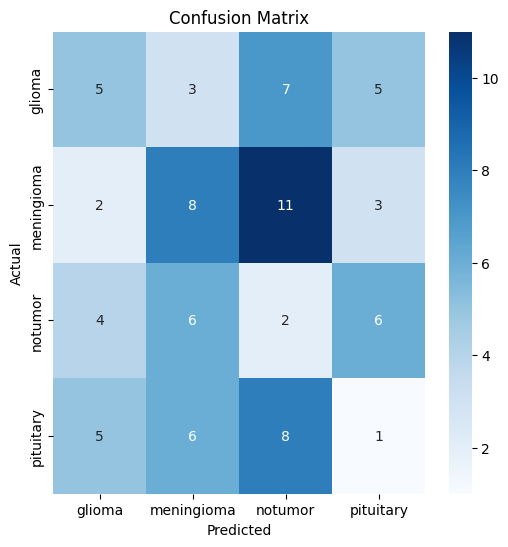

              precision    recall  f1-score   support

      glioma       0.31      0.25      0.28        20
  meningioma       0.35      0.33      0.34        24
     notumor       0.07      0.11      0.09        18
   pituitary       0.07      0.05      0.06        20

    accuracy                           0.20        82
   macro avg       0.20      0.19      0.19        82
weighted avg       0.21      0.20      0.20        82



In [61]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict all test samples
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# True labels
y_true = test_generator.classes

# Class labels
labels = list(test_generator.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=labels))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


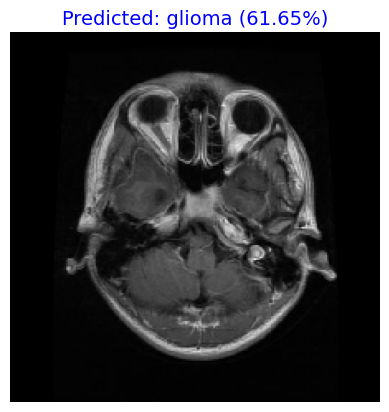

Actual class: glioma
Predicted class: glioma with 61.65% confidence


In [69]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the trained model
model = load_model("mobilenet_model.h5")

# Define test directory
test_dir = '/content/drive/MyDrive/Brain/Testing'

# Get class labels (only include actual directories)
class_labels = sorted([d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))])

# Randomly select a class folder
random_class = random.choice(class_labels)
class_path = os.path.join(test_dir, random_class)

# List only image files (ignore hidden/system files)
valid_extensions = ('.jpg', '.jpeg', '.png')
image_files = [f for f in os.listdir(class_path) if f.lower().endswith(valid_extensions)]

# Ensure at least one image exists
if not image_files:
    raise FileNotFoundError(f"No image files found in {class_path}")

# Randomly choose an image
random_image_name = random.choice(image_files)
img_path = os.path.join(class_path, random_image_name)

# Load and preprocess image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
predictions = model.predict(img_array)
predicted_index = np.argmax(predictions[0])
predicted_label = class_labels[predicted_index]
confidence = predictions[0][predicted_index]

# Display
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {predicted_label} ({confidence*100:.2f}%)", fontsize=14, color='blue')
plt.show()

print(f"Actual class: {random_class}")
print(f"Predicted class: {predicted_label} with {confidence*100:.2f}% confidence")
